In [1]:
############################################################
## CHARGEMENT DES BIBLIOTHEQUES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from umap import UMAP
from imblearn.over_sampling import SMOTE


############################################################
## FONCTIONS UTILES

# Fonction qui permet de charger un fichier json dans un dictionnaire
def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data


############################################################
## CHARGEMENT DU DATAFRAME

# On charge les données dans un dataframe "df"
df = pd.read_csv('../data/raw/terrorisme_sahel.csv')


############################################################
## FILTRAGE DE COLONNES

# On récupère ici seulement les évènements qui nous intéressent, ceux liés à des violences politiques
# On conserve 'Strategic developments' car elle permet de capturer le contexte
events_filter = ['Battles', 'Explosions/Remote violence',
                 'Violence against civilians', 'Strategic developments']

df = df[df['event_type'].isin(events_filter)]


############################################################
## CREATION DE NOUVELLES COLONNES

# On transforme la colonne "event_date" en datetime pour la manipuler plus facilement
df['event_date'] = pd.to_datetime(df['event_date'])

# On crée la colonne "month" en utilisant l'attribut month de datetime
df['month'] = df['event_date'].dt.month
# On ajoute la colonne juste après "year"
df.insert(3, 'month', df.pop('month'))

# On crée la colonne "day" en utilisant l'attribut day de datetime
df['day'] = df['event_date'].dt.day
# On ajoute la colonne juste après "month"
df.insert(5, 'day', df.pop('day'))


##
# On charge les données du fichier json "actor_type" dans un dictionnaire
# qui associe les valeurs des colonnes "inter1" et "inter2"
# au nom de chaque catégorie d'acteur (source : codebook ACLED)
actor_type = load_json_file("../references/actor_type.json")

# On convertit les clés du dictionnaire en entiers
actor_type = {int(k): v for k, v in actor_type.items()}

# On ajoute les colonnes "actor1_type" et "actor2_type" au dataframe
df['actor1_type'] = df['inter1'].map(actor_type)
df['actor2_type'] = df['inter2'].map(actor_type)


##
# On charge les données du fichier json "interaction_type" dans un dictionnaire
# associant aux valeurs de la colonne "interaction"
# les 2 acteurs impliqués dans une confrontation (source : codebook ACLED)
interaction_type = load_json_file("../references/interaction_type.json")

# On convertit les clés du dictionnaire en entiers
interaction_type = {int(k): v for k, v in interaction_type.items()}

# On ajoute une colonne "interaction_type" au dataframe
df['interaction_type'] = df['interaction'].map(interaction_type)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un des
# acteurs est une organisation terroriste

##
# On charge les données du fichier json "terrorist_group_filiation"
# dans un dictionnaire associant organisation terroriste et organisation mère
terrorist_group_filiation = load_json_file("../references/terrorist_group_filiation.json")

# On crée une liste contenant les organisations terroristes à partir des indices de ce dictionnaire
terrorist_groups = list(terrorist_group_filiation.keys())

# On crée une fonction pour vérifier si un acteur est une organisation terroriste
def is_terrorist_actor(actor):
    return actor in terrorist_groups

# On ajoute la colonne "is_terrorist_group_related" au dataframe
df['is_terrorist_group_related'] = (df['actor1'].apply(is_terrorist_actor) |
                             df['assoc_actor_1'].apply(is_terrorist_actor) |
                             df['actor2'].apply(is_terrorist_actor) |
                             df['assoc_actor_2'].apply(is_terrorist_actor)).astype(int)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un
# des acteurs est une pmc russe
pmc_groups = ['Wagner Group']

# On crée une fonction pour vérifier si un acteur est une pmc russe
def is_pmc_actor(actor):
    return actor in pmc_groups

# On ajoute la colonne "is_pmc_related" au dataframe
df['is_pmc_related'] = (df['actor1'].apply(is_pmc_actor) |
                             df['assoc_actor_1'].apply(is_pmc_actor) |
                             df['actor2'].apply(is_pmc_actor) |
                             df['assoc_actor_2'].apply(is_pmc_actor)).astype(int)


##
# On crée une fonction de mapping pour associer les valeurs du dictionnaire aux acteurs
# S'il n'y a pas de valeur on retourne "None" car cela veut simplement dire que l'évènement
# n'est pas lié à une organisation terroriste
def map_filiation(row):
    for actor in ['actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2']:
        if row[actor] in terrorist_group_filiation:
            return terrorist_group_filiation[row[actor]]
    return "None"

# On ajoute la colonne "terrorist_group_filiation" au dataframe
df['terrorist_group_filiation'] = df.apply(map_filiation, axis=1)


############################################################
## SUPPRESSION DE COLONNES

# On supprime les colonnes qui ne nous serons d'aucune utilité
columns_to_drop = [
    'time_precision',
    'disorder_type',
    'sub_event_type',
    'actor1',
    'assoc_actor_1',
    'actor2',
    'assoc_actor_2',
    'inter1',
    'inter2',
    'interaction',
    'admin2',
    'admin3',
    'iso',
    'region',
    'location',
    'latitude',
    'longitude',
    'geo_precision',
    'source',
    'source_scale',
    'notes',
    'tags',
    'timestamp',
    'civilian_targeting',
    'event_id_cnty'
]

df = df.drop(columns=columns_to_drop, axis=1)


############################################################
## GESTION DES VALEURS MANQUANTES

# Pour la colonne "actor2_type" on va remplacer les valeurs manquantes par "None" car cela
# indique juste que dans certains cas qu'il y a un seul acteur et pas un manque de valeur
df['actor2_type'] = df['actor2_type'].fillna("None")

# On affiche une première description statistique des variables
df.describe()
# On constate que les stats obtenues semblent correctes exceptée la valeur max pour la variable
# fatalities, ce qui peut indiquer tout simplement une journée très meurtrière.

# On récupère la ligne en question
df[df['fatalities'] == 179]
# Grâce à la date et aux autres infos (acteurs), on peut consulter l'actualité à cette époque
# et se rendre compte que cela correspond à un massacre qui a été perpétré par les forces Burkina
# contre des civils. On décidera de conserver cette valeur qui correspond à un évènement important
# qui peut avoir un impact sur notre analyse, mais pour réduire son impact sur les autres features,
# on fera une transformation logarithmique.


############################################################
## TRANSFORMATION DES DONNEES

def data_transformation(df, test_size=0.2, random_state=42):
    """
    Transforme les données pour l'entraînement et les tests.

    Args:
    - df: DataFrame contenant les données brutes.
    - test_size: La proportion de données à utiliser comme ensemble de test.
    - random_state: Utilisé pour initialiser le générateur de nombres aléatoires pour la reproductibilité.

    Returns:
    - X_train_encoded: Données d'entraînement après transformation.
    - X_test_encoded: Données de test après transformation.
    - y_train: Labels d'entraînement.
    - y_test: Labels de test.
    """

    # On trie notre dataframe par "event_date" par ordre croissant
    # pour que les données de test concernent les événements les plus récents
    df = df.sort_values(by='event_date', ascending=True)

    # Séparation des variables explicatives de notre variable cible
    X = df.drop(columns=['event_date', 'day', 'is_terrorist_group_related', 'terrorist_group_filiation', 'actor1_type', 'actor2_type'], axis=1)
    y = df['is_terrorist_group_related']

    # Division en ensembles d'entraînement et de test avec shuffle à False
    # pour que les données de test concernent les événements les plus récents (6 derniers mois)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=False)

    # Hot One Encoding des variables catégorielles après le split
    cat_columns = ['event_type', 'country', 'admin1', 'interaction_type']
    X_train_encoded = pd.get_dummies(X_train, columns=cat_columns, dtype=int)
    X_test_encoded = pd.get_dummies(X_test, columns=cat_columns, dtype=int)
    # On aligne les colonnes de X_test_encoded sur celles de X_train_encoded
    # pour s'assurer qu'ils ont les mêmes colonnes
    X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

    # On effectue une transformation logarithmique (avec log1p pour gérer les valeurs de fatalities à 0)
    X_train_encoded['fatalities'] = np.log1p(X_train_encoded['fatalities'])
    X_test_encoded['fatalities'] = np.log1p(X_test_encoded['fatalities'])

    # Initialisation d'un scaler pour les colonnes "month", "year" et "fatalities"
    scaler = StandardScaler()
    # On ajuste le scaler sur les données d'entraînement et on transforme les données d'entraînement et de test
    X_train_encoded[['year', 'month', 'fatalities']] = scaler.fit_transform(X_train_encoded[['year', 'month', 'fatalities']])
    X_test_encoded[['year', 'month', 'fatalities']] = scaler.transform(X_test_encoded[['year', 'month', 'fatalities']])

    # Transformation de la colonne 'month' sur les données d'entraînement et de test
    # en utilisant des fonctions trigonométriques pour capturer les variations cycliques
    X_train_encoded['month_sin'] = np.sin(2 * np.pi * X_train_encoded['month'] / 12)
    X_train_encoded['month_cos'] = np.cos(2 * np.pi * X_train_encoded['month'] / 12)
    X_test_encoded['month_sin'] = np.sin(2 * np.pi * X_test_encoded['month'] / 12)
    X_test_encoded['month_cos'] = np.cos(2 * np.pi * X_test_encoded['month'] / 12)

    # Suppression de la colonne 'month' après transformation
    X_train_encoded = X_train_encoded.drop(columns=['month'])
    X_test_encoded = X_test_encoded.drop(columns=['month'])

    # On applique un SMOTE uniquement sur l'ensemble d'entraînement
    # afin de rééquilibrer les classes
    smote = SMOTE(random_state=42)
    X_train_encoded, y_train = smote.fit_resample(X_train_encoded, y_train)

    return X_train, X_train_encoded, X_test, X_test_encoded, y_train, y_test


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'pandas.core.frame.DataFrame'>
Index: 14054 entries, 0 to 15074
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   event_date                  14054 non-null  datetime64[ns]
 1   year                        14054 non-null  int64         
 2   month                       14054 non-null  int32         
 3   day                         14054 non-null  int32         
 4   event_type                  14054 non-null  object        
 5   country                     14054 non-null  object        
 6   admin1                      14054 non-null  object        
 7   fatalities                  14054 non-null  int64         
 8   actor1_type                 14054 non-null  object        
 9   actor2_type                 13362 non-null  object        
 10  interaction_type            14054 non-null  object        
 11  is_terrorist_group_related  14054 non-null  int64         


In [2]:
############################################################
## MODELE RANDOM FOREST

# On récupère nos jeux d'entrainement et de test
X_train, X_train_encoded, X_test, X_test_encoded, y_train, y_test = data_transformation(df, test_size=0.2, random_state=42)

# On ajuste un modèle Random Forest
rf = RandomForestClassifier(n_jobs = -1)

# On cherche les meilleurs hyperparamètres de notre modèle avec un GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# On initialise GridSearchCV avec le modèle RF et la grille des paramètres
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc')

# On effectue la recherche de grille sur les données
grid_search.fit(X_train_encoded, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions du modèle RF
y_pred = grid_search.predict(X_test_encoded)
y_pred_prob = grid_search.predict_proba(X_test_encoded)[:, 1]

# On affiche les performances du modèle
print("Score RF :", grid_search.score(X_test_encoded, y_test))
print("AUC-ROC RF :", roc_auc_score(y_test, y_pred_prob))
print("\n## RAPPORT DE CLASSIFICATION RF")
print(classification_report(y_test, y_pred))

# On peut ensuite utiliser une validation croisée stratifiée pour évaluer la performance du modèle
# sur plusieurs sous-ensembles de données afin d'identifier s'il y a du surapprentissage
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# On utilise la métrique ROC-AUC comme méthode de scoring
sk_scores = cross_val_score(grid_search.best_estimator_, X_train_encoded, y_train, cv=stratified_kfold, scoring='roc_auc')
print("\n## VALIDATION CROISEE RF")
print(f'AUC-ROC scores for each fold: {sk_scores}')
print(f'Mean AUC-ROC: {sk_scores.mean()}')
print(f'Standard Deviation: {sk_scores.std()}')
# Les scores obtenus  entre les différentes folds semblent cohérents, avec une variance très faible,
# ce qui indique que le modèle Random Forest est robuste et fiable quant à sa capacité à
# généraliser aux données invisibles.

Meilleurs hyperparamètres : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Score RF : 0.9988987338086074
AUC-ROC RF : 0.9988987338086074

## RAPPORT DE CLASSIFICATION RF
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       724
           1       1.00      0.99      0.99      2087

    accuracy                           0.99      2811
   macro avg       0.98      0.99      0.98      2811
weighted avg       0.99      0.99      0.99      2811


## VALIDATION CROISEE RF
AUC-ROC scores for each fold: [0.99628324 0.99743858 0.99635556 0.99464202 0.99512196]
Mean AUC-ROC: 0.9959682719597176
Standard Deviation: 0.000988555580148807


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


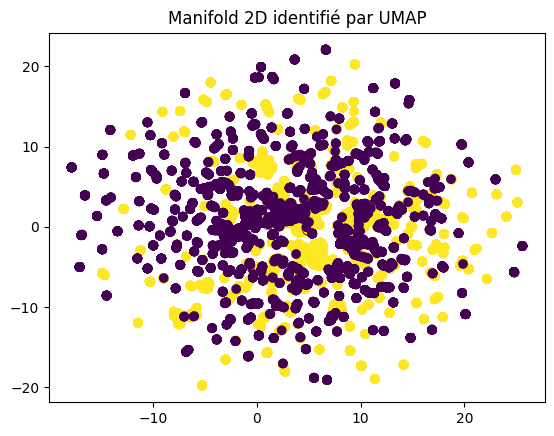

Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Score RF UMAP : 0.9547412024450228
AUC-ROC RF UMAP : 0.9547412024450228

## RAPPORT DE CLASSIFICATION RF UMAP
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       724
           1       0.96      0.93      0.95      2087

    accuracy                           0.92      2811
   macro avg       0.89      0.91      0.90      2811
weighted avg       0.92      0.92      0.92      2811


## VALIDATION CROISEE RF UMAP
AUC-ROC scores for each fold: [0.9957981  0.99705211 0.99512826 0.99374129 0.99406472]
Mean AUC-ROC: 0.9951568969840114
Standard Deviation: 0.0012000488348933723


In [3]:
############################################################
## MODELE RANDOM FOREST AVEC REDUCTION DE DIMENSION
## UMAP (non linéaire)

# On récupère nos jeux d'entrainement et de test
X_train, X_train_encoded, X_test, X_test_encoded, y_train, y_test = data_transformation(df, test_size=0.2, random_state=42)

# On instancie un modèle UMAP
umap_model = UMAP(n_neighbors = 15, min_dist = 0.1, n_components = 2)

# On transforme les données
X_train_umap = umap_model.fit_transform(X_train_encoded)
X_test_umap = umap_model.transform(X_test_encoded)

# On visualise la structure des données
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1],  c=y_train)
plt.title("Manifold 2D identifié par UMAP")
plt.show();

# On entraine un modèle RF sur les données réduites avec UMAP
rf = RandomForestClassifier(n_jobs = -1)

# On cherche les meilleurs hyperparamètres de notre modèle avec un GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# On initialise GridSearchCV avec le modèle RF et la grille des paramètres
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc')

# On effectue la recherche de grille sur les données
grid_search.fit(X_train_umap, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions du modèle sur les données réduites avec UMAP
y_pred = grid_search.predict(X_test_umap)
y_pred_prob = grid_search.predict_proba(X_test_umap)[:, 1]

# On affiche les scores
print("\nScore RF UMAP :", grid_search.score(X_test_umap, y_test))
print("AUC-ROC RF UMAP :", roc_auc_score(y_test, y_pred_prob))
print("\n## RAPPORT DE CLASSIFICATION RF UMAP")
print(classification_report(y_test, y_pred))

# On peut ensuite utiliser une validation croisée stratifiée pour évaluer la performance du modèle
# sur plusieurs sous-ensembles de données afin d'identifier s'il y a du surapprentissage
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# On utilise la métrique ROC-AUC comme méthode de scoring
sk_scores = cross_val_score(grid_search.best_estimator_, X_train_encoded, y_train, cv=stratified_kfold, scoring='roc_auc')
print("\n## VALIDATION CROISEE RF UMAP")
print(f'AUC-ROC scores for each fold: {sk_scores}')
print(f'Mean AUC-ROC: {sk_scores.mean()}')
print(f'Standard Deviation: {sk_scores.std()}')

In [4]:
############################################################
## MODELE SVM

# On récupère nos jeux d'entrainement et de test
X_train, X_train_encoded, X_test, X_test_encoded, y_train, y_test = data_transformation(df, test_size=0.2, random_state=42)

# On ajuste d'abord un modèle SVM sans réduction de dimension
# pour avoir un point de comparaison
svm = SVC()

# On cherche les meilleurs hyperparamètres de notre modèle avec un GridSearch
# On utilise des noyaux non linéaires, tels que RBF ou poly pour capturer
# des relations non linéaires dans les données
param_grid = {
    'C':[0.1,1,10],
    'kernel': ['rbf'],
    'gamma':[0.001, 0.1, 0.5]
}

# On initialise GridSearchCV avec le modèle SVM et la grille des paramètres
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid)

# On effectue la recherche de grille sur les données
grid_search.fit(X_train_encoded, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions du modèle SVM
y_pred = grid_search.predict(X_test_encoded)

# On affiche les performances du modèle
print("Score SVM :", grid_search.score(X_test_encoded, y_test))
print("\n## RAPPORT DE CLASSIFICATION SVM")
print(classification_report(y_test, y_pred))

# On peut ensuite utiliser une validation croisée stratifiée pour évaluer la performance du modèle
# sur plusieurs sous-ensembles de données afin d'identifier s'il y a du surapprentissage
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# On utilise la métrique ROC-AUC comme méthode de scoring
sk_scores = cross_val_score(grid_search.best_estimator_, X_train_encoded, y_train, cv=stratified_kfold, scoring='roc_auc')
print("\n## VALIDATION CROISEE SVM")
print(f'AUC-ROC scores for each fold: {sk_scores}')
print(f'Mean AUC-ROC: {sk_scores.mean()}')
print(f'Standard Deviation: {sk_scores.std()}')


Meilleurs hyperparamètres : {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Score SVM : 0.9683386695126289

## RAPPORT DE CLASSIFICATION SVM
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       724
           1       1.00      0.96      0.98      2087

    accuracy                           0.97      2811
   macro avg       0.95      0.98      0.96      2811
weighted avg       0.97      0.97      0.97      2811


## VALIDATION CROISEE SVM
AUC-ROC scores for each fold: [0.96949351 0.96648627 0.96616619 0.96421731 0.96722733]
Mean AUC-ROC: 0.9667181224880979
Standard Deviation: 0.0017073084327083952


In [5]:
############################################################
## MODELE SVM AVEC REDUCTION DE DIMENSION
## UMAP (non linéaire)

# On récupère nos jeux d'entrainement et de test
X_train, X_train_encoded, X_test, X_test_encoded, y_train, y_test = data_transformation(df, test_size=0.2, random_state=42)

# On instancie un modèle UMAP
umap_model = UMAP(n_neighbors = 15, min_dist = 0.1, n_components = 2)

# On transforme les données
X_train_umap = umap_model.fit_transform(X_train_encoded)
X_test_umap = umap_model.transform(X_test_encoded)

# On entraine un modèle SVM sur les données réduites avec UMAP
svm = SVC()

# On cherche les meilleurs hyperparamètres de notre modèle avec un GridSearch
# On utilise des noyaux non linéaires, tels que RBF ou poly pour capturer
# des relations non linéaires dans les données
param_grid = {
    'C':[0.1,1,10],
    'kernel': ['rbf'],
    'gamma':[0.001, 0.1, 0.5]
}

# On initialise GridSearchCV avec le modèle SVM et la grille des paramètres
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid)

# On effectue la recherche de grille sur les données
grid_search.fit(X_train_umap, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions du modèle SVM
y_pred = grid_search.predict(X_test_umap)

# On affiche les performances du modèle
print("Score SVM UMAP :", grid_search.score(X_test_umap, y_test))
print("\n## RAPPORT DE CLASSIFICATION SVM UMAP")
print(classification_report(y_test, y_pred))

# On peut ensuite utiliser une validation croisée stratifiée pour évaluer la performance du modèle
# sur plusieurs sous-ensembles de données afin d'identifier s'il y a du surapprentissage
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# On utilise la métrique ROC-AUC comme méthode de scoring
sk_scores = cross_val_score(grid_search.best_estimator_, X_train_umap, y_train, cv=stratified_kfold, scoring='roc_auc')
print("\n## VALIDATION CROISEE SVM UMAP")
print(f'AUC-ROC scores for each fold: {sk_scores}')
print(f'Mean AUC-ROC: {sk_scores.mean()}')
print(f'Standard Deviation: {sk_scores.std()}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Meilleurs hyperparamètres : {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
Score SVM UMAP : 0.9178228388473852

## RAPPORT DE CLASSIFICATION SVM UMAP
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       724
           1       0.96      0.93      0.94      2087

    accuracy                           0.92      2811
   macro avg       0.89      0.90      0.89      2811
weighted avg       0.92      0.92      0.92      2811


## VALIDATION CROISEE SVM UMAP
AUC-ROC scores for each fold: [0.96515086 0.9677961  0.96077909 0.95490297 0.9628754 ]
Mean AUC-ROC: 0.9623008837741326
Standard Deviation: 0.00437481096235945


In [6]:
############################################################
## MODELE KNN

# On récupère nos jeux d'entrainement et de test
X_train, X_train_encoded, X_test, X_test_encoded, y_train, y_test = data_transformation(df, test_size=0.2, random_state=42)

# On ajuste d'abord un modèle KNN sans réduction de dimension
# pour avoir un point de comparaison
knn = KNeighborsClassifier()

# On cherche les meilleurs hyperparamètres de notre modèle avec un GridSearch
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# On initialise GridSearchCV avec le modèle KNN et la grille des paramètres
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid)

# On effectue la recherche de grille sur les données
grid_search.fit(X_train_encoded, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions du modèle KNN
y_pred = grid_search.predict(X_test_encoded)
y_pred_prob = grid_search.predict_proba(X_test_encoded)[:, 1]

# On affiche les performances du modèle
print("Score KNN :", grid_search.score(X_test_encoded, y_test))
print("\n## RAPPORT DE CLASSIFICATION KNN")
print(classification_report(y_test, y_pred))

# On peut ensuite utiliser une validation croisée stratifiée pour évaluer la performance du modèle
# sur plusieurs sous-ensembles de données afin d'identifier s'il y a du surapprentissage
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# On utilise la métrique ROC-AUC comme méthode de scoring
sk_scores = cross_val_score(grid_search.best_estimator_, X_train_encoded, y_train, cv=stratified_kfold, scoring='roc_auc')
print("\n## VALIDATION CROISEE KNN")
print(f'AUC-ROC scores for each fold: {sk_scores}')
print(f'Mean AUC-ROC: {sk_scores.mean()}')
print(f'Standard Deviation: {sk_scores.std()}')

Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Score KNN : 0.9686944147990039

## RAPPORT DE CLASSIFICATION KNN
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       724
           1       0.99      0.97      0.98      2087

    accuracy                           0.97      2811
   macro avg       0.95      0.97      0.96      2811
weighted avg       0.97      0.97      0.97      2811


## VALIDATION CROISEE KNN
AUC-ROC scores for each fold: [0.98869876 0.98967496 0.98727192 0.98520676 0.98637082]
Mean AUC-ROC: 0.9874446435750942
Standard Deviation: 0.0015961307626373


In [7]:
############################################################
## MODELE KNN AVEC REDUCTION DE DIMENSION
## UMAP (non linéaire)

# On récupère nos jeux d'entrainement et de test
X_train, X_train_encoded, X_test, X_test_encoded, y_train, y_test = data_transformation(df, test_size=0.2, random_state=42)

# On instancie un modèle UMAP
umap_model = UMAP(n_neighbors = 15, min_dist = 0.1, n_components = 2)

# On transforme les données
X_train_umap = umap_model.fit_transform(X_train_encoded)
X_test_umap = umap_model.transform(X_test_encoded)

# On entraine un modèle KNN sur les données réduites avec UMAP
knn = KNeighborsClassifier()

# On cherche les meilleurs hyperparamètres de notre modèle avec un GridSearch
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# On initialise GridSearchCV avec le modèle KNN et la grille des paramètres
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid)

# On effectue la recherche de grille sur les données
grid_search.fit(X_train_umap, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions du modèle KNN
y_pred = grid_search.predict(X_test_umap)

# On affiche les performances du modèle
print("Score KNN UMAP :", grid_search.score(X_test_umap, y_test))
print("\n## RAPPORT DE CLASSIFICATION KNN UMAP")
print(classification_report(y_test, y_pred))

# On peut ensuite utiliser une validation croisée stratifiée pour évaluer la performance du modèle
# sur plusieurs sous-ensembles de données afin d'identifier s'il y a du surapprentissage
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# On utilise la métrique ROC-AUC comme méthode de scoring
sk_scores = cross_val_score(grid_search.best_estimator_, X_train_umap, y_train, cv=stratified_kfold, scoring='roc_auc')
print("\n## VALIDATION CROISEE KNN UMAP")
print(f'AUC-ROC scores for each fold: {sk_scores}')
print(f'Mean AUC-ROC: {sk_scores.mean()}')
print(f'Standard Deviation: {sk_scores.std()}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Score KNN UMAP : 0.9181785841337602

## RAPPORT DE CLASSIFICATION KNN UMAP
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       724
           1       0.96      0.93      0.94      2087

    accuracy                           0.92      2811
   macro avg       0.89      0.91      0.90      2811
weighted avg       0.92      0.92      0.92      2811


## VALIDATION CROISEE KNN UMAP
AUC-ROC scores for each fold: [0.97158889 0.97773299 0.9754223  0.97196498 0.96482669]
Mean AUC-ROC: 0.9723071741926678
Standard Deviation: 0.00437570904125062


In [8]:
############################################################
## MODELE XGBOOST

# On récupère nos jeux d'entrainement et de test
X_train, X_train_encoded, X_test, X_test_encoded, y_train, y_test = data_transformation(df, test_size=0.2, random_state=42)

# Initialisation du modèle XGBoost avec XGBClassifier
xgb_model = xgb.XGBClassifier()

# Définition des paramètres à optimiser
param_grid = {
    'booster': ['gbtree', 'gblinear'],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Configuration de GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Entraînement du modèle avec GridSearchCV
grid_search.fit(X_train_encoded, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions sur l'ensemble de test
y_pred = grid_search.predict(X_test_encoded)
y_pred_prob = grid_search.predict_proba(X_test_encoded)[:, 1]

# On affiche les performances du modèle
print("Score XGBOOST :", grid_search.score(X_test_encoded, y_test))
print("\n## RAPPORT DE CLASSIFICATION XGBOOST")
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [01:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [01:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [01:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [01:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

Meilleurs hyperparamètres : {'booster': 'gblinear', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300}
Score XGBOOST : 0.991462113127001

## RAPPORT DE CLASSIFICATION XGBOOST
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       724
           1       0.99      1.00      0.99      2087

    accuracy                           0.99      2811
   macro avg       0.99      0.99      0.99      2811
weighted avg       0.99      0.99      0.99      2811



In [9]:
############################################################
## PREDICTIONS POUR LES 6 PROCHAINS MOIS
# AVEC UN MODELE KNN

# On récupère nos jeux d'entrainement et de test
X_train, X_train_encoded, X_test, X_test_encoded, y_train, y_test = data_transformation(df, test_size=0.2, random_state=42)

# On ajuste d'abord un modèle KNN sans réduction de dimension
# pour avoir un point de comparaison
knn = KNeighborsClassifier()

# On cherche les meilleurs hyperparamètres de notre modèle avec un GridSearch
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# On initialise GridSearchCV avec le modèle KNN et la grille des paramètres
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid)

# On effectue la recherche de grille sur les données
grid_search.fit(X_train_encoded, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions du modèle KNN
y_pred = grid_search.predict(X_test_encoded)
y_pred_prob = grid_search.predict_proba(X_test_encoded)

# On affiche les performances du modèle
print("Score KNN :", grid_search.score(X_test_encoded, y_test))
print("\n## RAPPORT DE CLASSIFICATION KNN")
print(classification_report(y_test, y_pred))

# On peut ensuite utiliser une validation croisée stratifiée pour évaluer la performance du modèle
# sur plusieurs sous-ensembles de données afin d'identifier s'il y a du surapprentissage
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# On utilise la métrique ROC-AUC comme méthode de scoring
sk_scores = cross_val_score(grid_search.best_estimator_, X_train_encoded, y_train, cv=stratified_kfold, scoring='roc_auc')
print("\n## VALIDATION CROISEE KNN")
print(f'AUC-ROC scores for each fold: {sk_scores}')
print(f'Mean AUC-ROC: {sk_scores.mean()}')
print(f'Standard Deviation: {sk_scores.std()}')

Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Score KNN : 0.9686944147990039

## RAPPORT DE CLASSIFICATION KNN
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       724
           1       0.99      0.97      0.98      2087

    accuracy                           0.97      2811
   macro avg       0.95      0.97      0.96      2811
weighted avg       0.97      0.97      0.97      2811


## VALIDATION CROISEE KNN
AUC-ROC scores for each fold: [0.98869876 0.98967496 0.98727192 0.98520676 0.98637082]
Mean AUC-ROC: 0.9874446435750942
Standard Deviation: 0.0015961307626373


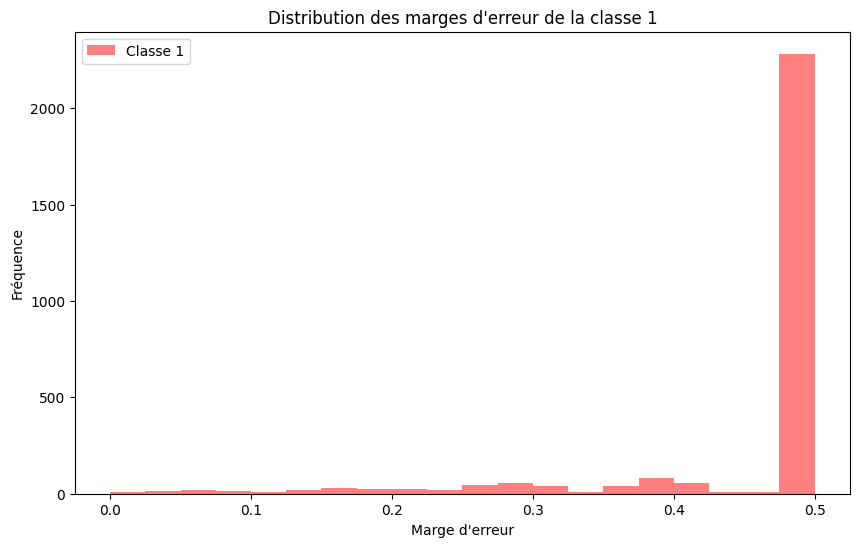

In [10]:
##
# Regroupement des données par pays et mois

# On ajoute les prédictions à l'ensemble de test
df_test = X_test.copy()
df_test['is_terrorist_group_related'] = y_test
df_test['predicted_is_terrorist_group_related'] = y_pred

# Ajout au dataframe des probabilités prédites pour la classe 1
df_test['predicted_prob_class_1'] = y_pred_prob[:, 1]

# Ajout au dataframe des marges d'erreur au dataframe
df_test['margin_of_error_class_1'] = np.abs(y_pred_prob[:, 1] - 0.5)

# Création d'une nouvelle colonne 'event_date' à partir des colonnes 'year' et 'month'
df_test['event_date'] = pd.to_datetime(df_test['year'].astype(str) + '-' + df_test['month'].astype(str), format='%Y-%m')

df_test['event_date'] = df_test['event_date'].dt.strftime('%Y-%m')


##
# On crée un dataframe qui résume par pays pour chaque mois
# le nombre d'événements
# le nombre d'événements prédits
# la probabilité moyenne de la classe 1
# la marge d'erreur moyenne de la classe 1
df_summary_country = df_test.groupby(['country', 'event_date']).agg({
    'event_type': 'count',
    'predicted_is_terrorist_group_related': 'sum',
    'predicted_prob_class_1': 'mean',
    'margin_of_error_class_1': 'mean'
})

# Renommage des colonnes pour plus de clarté
df_summary_country.columns = ['events',
                      'predicted_events', 
                      'avg_predicted_prob_class_1', 
                      'avg_margin_of_error_class_1']

# Réinitialisation de l'index pour obtenir un DataFrame ordinaire
df_summary_country = df_summary_country.reset_index()
# On observe que c'est pour le Mali que les prédictions sont les moins précises


##
# On crée un dataframe qui résume par sous-région pour chaque mois
# le nombre d'événements
# le nombre d'événements prédits
# la probabilité moyenne de la classe 1
# la marge d'erreur moyenne de la classe 1
df_summary_admin1 = df_test.groupby(['country', 'admin1', 'event_date']).agg({
    'event_type': 'count',
    'predicted_is_terrorist_group_related': 'sum',
    'predicted_prob_class_1': 'mean',
    'margin_of_error_class_1': 'mean'
})

# Renommage des colonnes pour plus de clarté
df_summary_admin1.columns = ['events',
                      'predicted_events', 
                      'avg_predicted_prob_class_1', 
                      'avg_margin_of_error_class_1']

# Réinitialisation de l'index pour obtenir un DataFrame ordinaire
df_summary_admin1 = df_summary_admin1.reset_index()


##
# On trace un histogramme de la distribution des marges d'erreur de la classe 1
margin_of_error_class_1 = np.abs(y_pred_prob[:, 1] - 0.5)
plt.figure(figsize=(10, 6))
plt.hist(margin_of_error_class_1, bins=20, alpha=0.5, label='Classe 1', color='red')
plt.xlabel('Marge d\'erreur')
plt.ylabel('Fréquence')
plt.title('Distribution des marges d\'erreur de la classe 1')
plt.legend()
plt.show();

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_15728/1350033456.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorist_events = df_test[df_test['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_15728/1350033456.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicted_terrorist_events = df_test[df_test['predicted_is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()


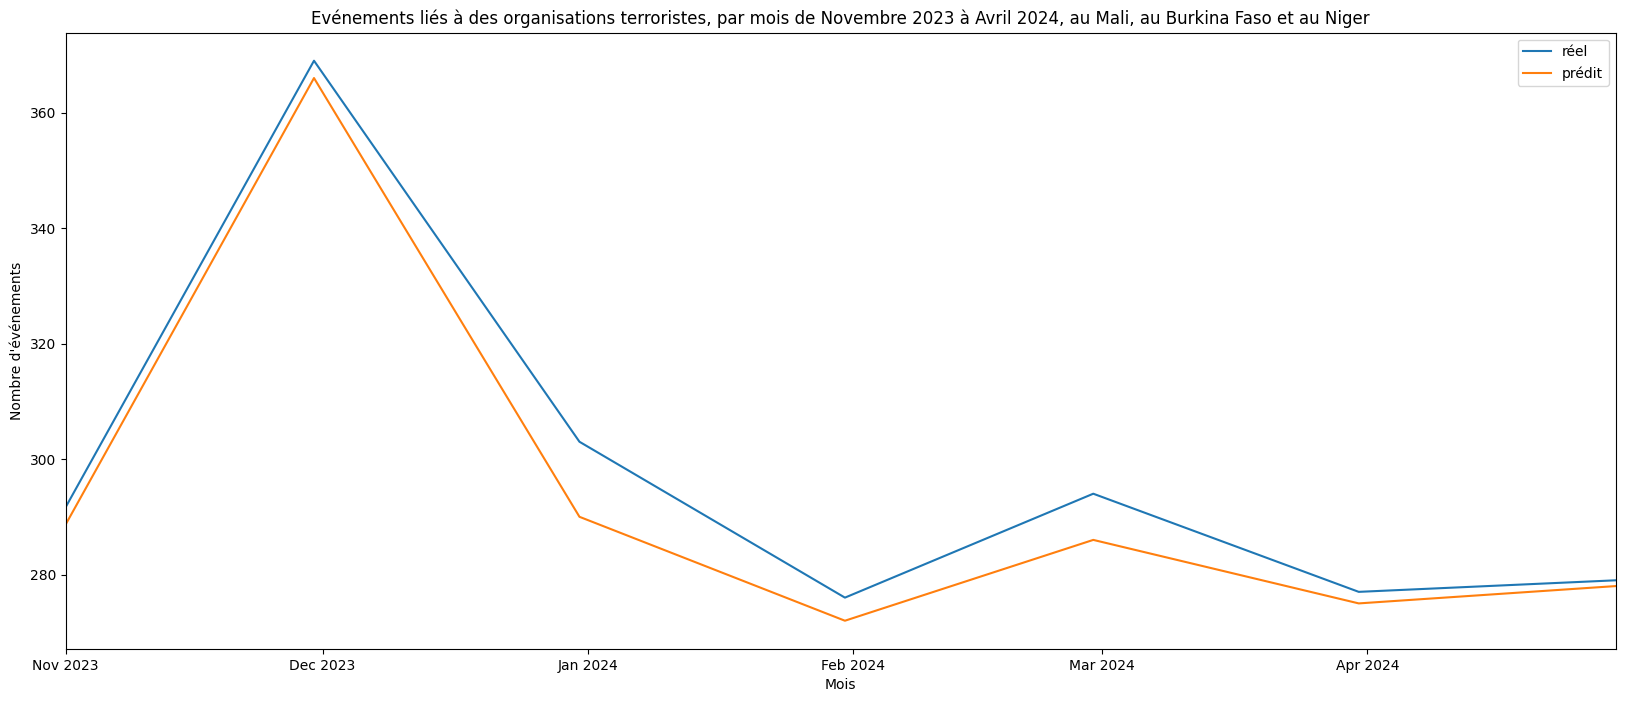

In [12]:
##
# Visualisation des prédictions par rapport au réel
# par mois de Novembre 2023 à Avril 2024
# au Mali, au Burkina Faso et au Niger
# des les événements liés à des organisations terroristes

# On crée une série qui permet de grouper et de compter par mois
# les évènements liés à des violences perpétrées par des organisations terroristes
df_test['event_date'] = pd.to_datetime(df_test['year'].astype(str) + '-' + df_test['month'].astype(str), format='%Y-%m')

terrorist_events = df_test[df_test['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()

# On crée une série qui permet de grouper et de compter par mois
# les évènements liés à des violences perpétrées par des organisations terroristes qui ont été prédit
predicted_terrorist_events = df_test[df_test['predicted_is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()

# On trace un diagramme à barres afin d'afficher le nombre d'évènements par mois
# liés à des violences perpétrées par des organisations terroristes
# ainsi que les violences politiques quelque soit l'acteur
plt.figure(figsize=(20, 8))
borne_inf = pd.Timestamp('2023-11-01')
borne_sup = pd.Timestamp('2024-04-30')
plt.xlim(borne_inf, borne_sup)
plt.plot(terrorist_events.index, terrorist_events.values, label='réel')
plt.plot(predicted_terrorist_events.index, predicted_terrorist_events.values, label='prédit')
plt.xlabel('Mois')
plt.ylabel("Nombre d'événements")
plt.title("Evénements liés à des organisations terroristes, par mois de Novembre 2023 à Avril 2024, au Mali, au Burkina Faso et au Niger")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.legend()
plt.show();